Training:

    1. This notebook is not a holistic training process but the last step of the iterative training, where the model was training on different sub-dataset separatly regarding to the limited resouces.
    
    2. The weight of model was saved and loadded each time, till the model complete all the data. 
    
    3. U-net model is used for this segmentation task. Chinese tutorial:https://www.bilibili.com/video/BV1yB4y1z7mj/?spm_id_from=333.337.search-card.all.click&vd_source=d874767b0762230d0ad77127a6387d7b
    
    4. You are expected to adjust the size of model according to the volume of dataset.

In [1]:
import os
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from keras.models import Model
#from keras.optimizers import Adam
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import array_to_img


In [3]:
def Unet():
    # contraction path
    # Input layer data is a 256x256 three-channel image
    inputs = tf.keras.Input(shape=[256, 256, 3])
    
    # First block (including two convolutional layers with ReLU activation function, and a convolutional max-pooling operation)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Second block
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Third block
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Fourth block
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # expansive path
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    
    # Optimizer is Adam, loss function is binary_crossentropy, evaluation metric is accuracy
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model


In [4]:
unet = Unet()

2023-07-21 11:59:53.463897: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 11:59:54.397851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1b:00.0, compute capability: 8.6


In [5]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [6]:
unet.load_weights("Final_weights/sc_lr0.0001_im4_sub3.h5")

In [7]:
#first call for computing graph
res_train_im = np.load('./train_im_4/train_im_sub_arrays4.npy')
res_train_la = np.load('./single_channel_la/tr_sc_sub4o4.npy')
res_Val_im = np.load('./Val_im_4/Val_im_sub_arrays1.npy')
res_Val_la = np.load('./single_channel_la/va_sc_sub1o4.npy')

In [8]:
%%time
unet.fit(res_train_im, res_train_la, validation_data=(res_Val_im, res_Val_la), batch_size=16, epochs=30)


Epoch 1/30


2023-07-21 12:01:32.806867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


384/384 [==============================] - 113s 275ms/step - loss: 0.0577 - accuracy: 0.9786 - val_loss: 0.0515 - val_accuracy: 0.9797
Epoch 2/30
384/384 [==============================] - 98s 254ms/step - loss: 0.0378 - accuracy: 0.9856 - val_loss: 0.0428 - val_accuracy: 0.9848
Epoch 3/30
384/384 [==============================] - 98s 255ms/step - loss: 0.0288 - accuracy: 0.9890 - val_loss: 0.0874 - val_accuracy: 0.9783
Epoch 4/30
384/384 [==============================] - 98s 255ms/step - loss: 0.0247 - accuracy: 0.9904 - val_loss: 0.0492 - val_accuracy: 0.9837
Epoch 5/30
384/384 [==============================] - 98s 255ms/step - loss: 0.0232 - accuracy: 0.9910 - val_loss: 0.0677 - val_accuracy: 0.9816
Epoch 6/30
384/384 [==============================] - 98s 255ms/step - loss: 0.0235 - accuracy: 0.9909 - val_loss: 0.0733 - val_accuracy: 0.9808
Epoch 7/30
384/384 [==============================] - 98s 255ms/step - loss: 0.0197 - accuracy: 0.9923 - val_loss: 0.0552 - val_accuracy: 0.

In [9]:
unet.save_weights("Final_weights/sc_lr0.0001_im4_sub4.h5")

In [10]:
#%%time
#unet.fit(res_train_im, res_train_la, validation_data=(res_Val_im, res_Val_la), batch_size=16, epochs=20)


In [11]:
y_pred = unet.predict(res_Val_im)

In [13]:
y_pred[8]

array([[[2.00374052e-03],
        [4.02908452e-04],
        [8.30151621e-05],
        ...,
        [1.16491894e-04],
        [4.39463620e-04],
        [1.33059360e-03]],

       [[7.40712741e-04],
        [2.52857251e-04],
        [3.54029471e-05],
        ...,
        [7.52494961e-05],
        [2.06638084e-04],
        [3.52263247e-04]],

       [[4.05730039e-04],
        [3.12750162e-05],
        [4.29438796e-06],
        ...,
        [8.07316883e-06],
        [7.62042182e-05],
        [2.11182458e-04]],

       ...,

       [[2.25868844e-03],
        [3.09625961e-04],
        [1.17390671e-04],
        ...,
        [8.02701048e-04],
        [3.83324618e-03],
        [9.74733755e-03]],

       [[3.61817004e-03],
        [7.61123374e-04],
        [2.65366398e-04],
        ...,
        [2.51210853e-03],
        [4.69258940e-03],
        [1.00665428e-02]],

       [[4.42897901e-03],
        [1.44282123e-03],
        [4.68560931e-04],
        ...,
        [4.15084139e-03],
        [5.7092

In [68]:
def plot_sample(x, y_true, y_pred, threshold=0.01):
    # Generate the predicted label
    y_pred_labels = tf.cast(y_pred >= threshold, tf.float32)
    #y_pred_labels =  y_pred
    # Plot the sample
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(x)
    axes[0].set_title('Original Image')
    axes[1].imshow(y_true)
    axes[1].set_title('True Label')
    axes[2].imshow(y_pred_labels)
    axes[2].set_title('Predicted Label')
    plt.show()
    


In [64]:
# Convert data to supported dtypes
test_im0 = res_Val_im[7].astype(np.float32)
test_la0 = res_Val_la[7].astype(np.float32)
#y_pred0 = y_pred.astype(np.float32)

# Ensure values are in the appropriate range (e.g., [0, 1] for float32)
#test_im0 /= 255.0
#test_la0 /= 255.0
#y_pred0 /= 255.0

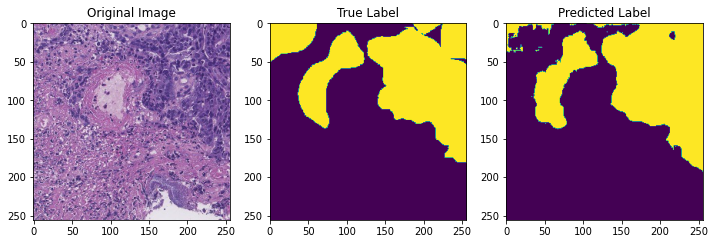

In [69]:
plot_sample(test_im0, test_la0, y_pred[7])